<a href="https://colab.research.google.com/github/ttjh1234/Study_MLDL/blob/main/chapter09_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 과 GRU 셀

이번 절에서는 고급 순환층인 LSTM과 GRU에 대해 공부한다.

일반적으로 기본 순환층은 긴 시퀀스를 학습하기 어렵다. 

시퀀스가 길수록 순환되는 은닉 상태에 담기 정보가 점차 희석되기 떄문이다.

멀리 떨어져 있는 단어 정보를 인식하는 데 어려울 수 있다. 

이를 위해 LSTM과 GRU 셀이 발명되었다.

## LSTM 신경망 훈련하기

**LSTM**은 Long Short-Term Memory 의 약자이다. 즉, 단기 기억을 오래 기억하기 위해 고안되었다.

LSTM은 Cell State 와 Hidden State의 이원화로 구성되어있다.

기억할 것은 오래 기억하고, 버릴 것은 빨리 버린다. => 학습 매개변수가 많아서 최적화가 어렵다.

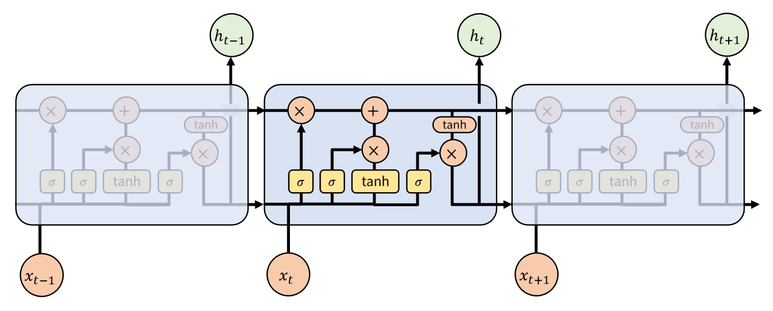

Cell State : 위쪽 검은 라인으로 이어지는 출력 : 더하기 연산으로 값을 계속 더해간다.

Hidden State : 아래쪽 검은 라인의 출력, 현재 단계의 출력을 계속 다음 단계로 넘긴다.



**LSTM의 Forget/ Input/ Output Gate**

Sigmoid 함수(0~1값) 를 적용하여 주어진 값을 무시할지(0), 어느 정도 반영할지 결정하는 3개의 게이트

* Forget Gate :  이전 단계의 Cell State 값을 얼마나 이용할지, 버릴지 결정
* Input Gate : 입력값에서 tanh를 적용하여 나온 새로운 Feature를 얼마나 반영할지 결정
* Output Gate : 현재 단계의 출력을 이후 단계로 보낼 때 얼마나 반영할지 결정. tanh가 또 있는 것은 Cell State 연산에서 더하기 연산에 의해 나온 결과를 다시 -1~1 의 값으로 하기 위해서 존재한다.



데이터는 앞 절에서 사용하였던 IMDB 리뷰 dataset을 계속 사용한다.

앞 절에서와 마찬가지로 어휘 사전의 크기를 500으로 하고, train_set,valid_set,test_set을 나눠준다.

In [1]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=500)
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

데이터를 분할하고, 각 리뷰 데이터들을 100개의 토큰으로 나누고, 패딩을 진행한다.

이 때 전 절에서 사용한 것과 같이 **pad_sequences()**를 사용한다.

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train_seq=pad_sequences(x_train,maxlen=100)
x_valid_seq=pad_sequences(x_valid,maxlen=100)

데이터의 기본적인 처리가 끝나면, 이제 신경망 모델을 만든다.

원 핫 인코딩을 사용하지않고 16 크기의 벡터를 사용하여 단어임베딩을 사용한다.

임베딩 층이 끝난 후, LSTM 순환 신경망층을 뉴런의 개수 8개를 지정하여 사용한다.


In [4]:
from tensorflow import keras
model=keras.Sequential()
model.add(keras.layers.Embedding(500,16,input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           8000      
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


전 절에서 사용했던 SimpleRNN과 같은 뉴런 수이지만, LSTM은 총 4개의 셀로 이루어져 있어, 전 절에서 200개의 파라미터를 가졌지만 이번에는 800개를 가진다.

간단한 계산 : (16\*8+8\*8+8)\*4=800

이제 RMSprop 옵티마이저의 학습률을 조정하여 신경망을 훈련시키겠다.

조기종료와 저장을 위한 콜백을 지정하였고, 에포크는 100, 배치 사이즈는 64로 지정하였다.

In [6]:
rmsprop=keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history=model.fit(x_train_seq,y_train,epochs=100,batch_size=64,validation_data=(x_valid_seq,y_valid),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 9ms/step - loss: 0.6926 - accuracy: 0.5427 - val_loss: 0.6906 - val_accuracy: 0.6144
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6888 - accuracy: 0.6345 - val_loss: 0.6788 - val_accuracy: 0.6810
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6606 - accuracy: 0.6906 - val_loss: 0.6055 - val_accuracy: 0.6948
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5954 - accuracy: 0.7047 - val_loss: 0.5793 - val_accuracy: 0.7194
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5665 - accuracy: 0.7344 - val_loss: 0.5590 - val_accuracy: 0.7378
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5459 - accuracy: 0.7514 - val_loss: 0.5431 - val_accuracy: 0.7436
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5291 - accuracy: 0.7648 - val_loss: 0.5271 - val_accuracy: 0.759

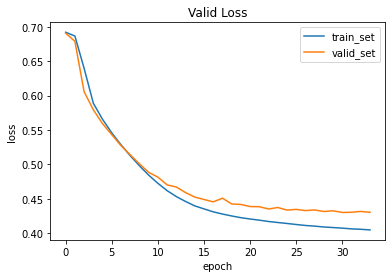

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_set','valid_set'])
plt.title('Valid Loss')
plt.show()

그래프를 보면 SimpleRNN 보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행한 것으로 보인다.

하지만 경우에 따라서 과대적합을 더 강하게 제어할 필요가 있다. 

과대적합을 맞기 위해 인공 신경망에서 사용하였던 드롭아웃을 적용해보겠다.

## 순환층에 드롭아웃 적용하기

이전에 배웠던 완전 연결 신경망과 합성곱 신경망에서는 Dropout 클래스를 사용해 드롭아웃을 적용했다.

이는 모델이 훈련세트에 너무 과대적합되는 것을 막아주는 역할을 했다.

순환층은 자체적으로 드롭아웃 기능을 제공한다.

**SimpleRNN과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있다.**

dropout 매개변수는 셀의 입력에 드롭아웃을 적용하고, recurrent_dropout은 순환되는 은닉 상태에 드롭아웃을 적용한다.

기술적인 문제로 recurrent_dropout을 사용하면 GPU를 사용하여 모델을 훈련하지 못한다.

따라서 dropout 매개변수만 사용해서 전과 동일하게 모델을 훈련시키겠다.

In [9]:
model2=keras.Sequential()
model2.add(keras.layers.Embedding(500,16,input_length=100))
model2.add(keras.layers.LSTM(8,dropout=0.3))
model2.add(keras.layers.Dense(1,activation='sigmoid'))

In [10]:
rmsprop=keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-dropout-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history=model2.fit(x_train_seq,y_train,epochs=100,batch_size=64,validation_data=(x_valid_seq,y_valid),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 4s 8ms/step - loss: 0.6927 - accuracy: 0.5222 - val_loss: 0.6914 - val_accuracy: 0.5634
Epoch 2/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6900 - accuracy: 0.5794 - val_loss: 0.6864 - val_accuracy: 0.6208
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6825 - accuracy: 0.6240 - val_loss: 0.6611 - val_accuracy: 0.6594
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6358 - accuracy: 0.6794 - val_loss: 0.5916 - val_accuracy: 0.7276
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5840 - accuracy: 0.7231 - val_loss: 0.5657 - val_accuracy: 0.7504
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5535 - accuracy: 0.7489 - val_loss: 0.5440 - val_accuracy: 0.7664
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5390 - accuracy: 0.7590 - val_loss: 0.5208 - val_accuracy: 0.7712

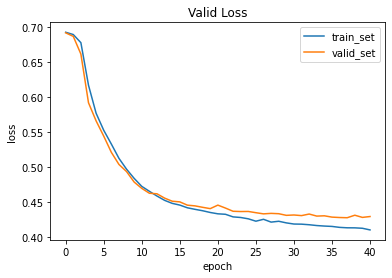

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_set','valid_set'])
plt.title('Valid Loss')
plt.show()

LSTM 층에 적용한 드롭아웃이 효과가 있는 것 같다.

훈련 손실과 검증 손실 간의 차이가 좁아졌다.

밀집층이나 합성곱 층 처럼 순환층도 여러 개를 쌓을 수 있다. 그 방법에 대해서 알아보겠다.

## 2개의 층을 연결하기

순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달한다.

하지만 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요하므로, 이를 해결하기 위해서는 앞쪽의 순환층의 모든 타임스텝에 대한 은닉 상태를 출력해야 한다.

케라스의 순환층에서 모든 타임스텝의 은닉 상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 **return_sequences** 매개변수를 지정하면 된다.

앞에서 적용한 dropout을 적용하고 LSTM 층을 한 개 더 생성해 2개의 순환층을 가진 신경망을 훈련시키겠다.

In [12]:
model3=keras.Sequential()
model3.add(keras.layers.Embedding(500,16,input_length=100))
model3.add(keras.layers.LSTM(8,dropout=0.3,return_sequences=True))
model3.add(keras.layers.LSTM(8,dropout=0.3))
model3.add(keras.layers.Dense(1,activation='sigmoid'))

In [13]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 8)            800       
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
rmsprop=keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-twolayer-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history=model3.fit(x_train_seq,y_train,epochs=100,batch_size=64,validation_data=(x_valid_seq,y_valid),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 7s 12ms/step - loss: 0.6928 - accuracy: 0.5347 - val_loss: 0.6916 - val_accuracy: 0.6202
Epoch 2/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6904 - accuracy: 0.6179 - val_loss: 0.6843 - val_accuracy: 0.6458
Epoch 3/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6760 - accuracy: 0.6476 - val_loss: 0.6304 - val_accuracy: 0.6874
Epoch 4/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6038 - accuracy: 0.6959 - val_loss: 0.5554 - val_accuracy: 0.7268
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5489 - accuracy: 0.7293 - val_loss: 0.5231 - val_accuracy: 0.7488
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5203 - accuracy: 0.7539 - val_loss: 0.5070 - val_accuracy: 0.7620
Epoch 7/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5042 - accuracy: 0.7598 - val_loss: 0.4899 - val_accuracy:

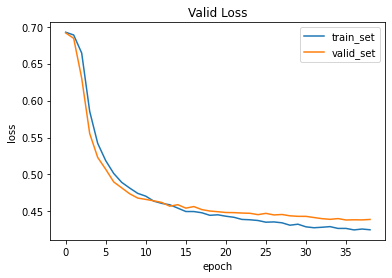

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_set','valid_set'])
plt.title('Valid Loss')
plt.show()

일반적으로 순환층을 쌓으면 성능이 높아지는데, 이 예에서는 큰 효과를 내진 못한 것 같다.

손실 그래프를 보면 과대적합을 제어하면서 손실을 최대한 낮춘 것 같다.

지금까지 LSTM을 사용하여 훈련을 시켰는데, GRU 셀을 배워보겠다.

## GRU 신경망 훈련하기

GRU는 Gated Reccurent Unit 의 약자로, 뉴욕 대학교 조경현 교수가 발명한 셀로 유명하다.

이 셀은 LSTM을 간소화한 버전으로 생각할 수 있다.

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있다.

2개는 sigmoid 활성화 함수를, 1개는 tanh 활성화 함수를 사용한다.

GRU에서는 Forget Gate 와 Input Gate를 하는 일을 Update Gate에서 하는데, Forget과 Input을 더하면 1이 되게 해서 상호 보완되게 했다.

즉 Forget + Input = 1 => Input= 1- Forget

Reset Gate는 이전 단계의 출력을 얼마만큼 Update Gate의 입력으로 넣을지 결정해준다.




GRU 셀을 사용하여 모델을 만들어보겠다.

LSTM 순환층을 사용한 것과 마찬가지로, 단어 임베딩을 하고 나서 GRU 순환층을 사용한다.

In [16]:
model4=keras.Sequential()
model4.add(keras.layers.Embedding(500,16,input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1,activation='sigmoid'))

In [17]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
gru (GRU)                    (None, 8)                 624       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


LSTM은 SimpleRNN에 비해 작은 셀이 4개가 더 존재하여 총 파라미터가 4배가 되었는데, 같은 방식으로 GRU도 파라미터가 600개가 될 거라고 생각한다.

텐서플로에 기본적으로 구현된 GRU 셀의 계산은 살짝 다르다.

이 이유는 텐서플로가 GPU를 잘 활용하기 위해서 내부적으로 계산하는 방식이 틀리기 때문이다.

In [18]:
rmsprop=keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-gru-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history=model4.fit(x_train_seq,y_train,epochs=100,batch_size=64,validation_data=(x_valid_seq,y_valid),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 4s 8ms/step - loss: 0.6925 - accuracy: 0.5317 - val_loss: 0.6915 - val_accuracy: 0.5598
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6909 - accuracy: 0.5650 - val_loss: 0.6895 - val_accuracy: 0.5784
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6884 - accuracy: 0.5878 - val_loss: 0.6860 - val_accuracy: 0.5910
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6839 - accuracy: 0.6089 - val_loss: 0.6799 - val_accuracy: 0.6094
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6765 - accuracy: 0.6232 - val_loss: 0.6699 - val_accuracy: 0.6228
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6643 - accuracy: 0.6426 - val_loss: 0.6533 - val_accuracy: 0.6432
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6436 - accuracy: 0.6636 - val_loss: 0.6231 - val_accuracy: 0.6700

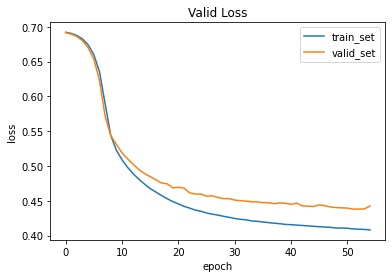

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_set','valid_set'])
plt.title('Valid Loss')
plt.show()

드롭아웃을 사용하지 않았기 때문에 이전보다 훈련 손실과 검증 손실 간에 차이가 있지만, 훈련 과정이 잘 수렴되고 있는 것 같다.

## 모델 평가

In [21]:
x_test_seq=pad_sequences(x_test,maxlen=100)
rnn_model=keras.models.load_model('best-twolayer-model.h5')
rnn_model.evaluate(x_test_seq,y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.4336 - accuracy: 0.7974


[0.43360409140586853, 0.7973999977111816]

모델에 대한 평가는 LSTM 순환층을 2개를 사용한 모델을 불러와 test_set을 적용시켰을 때의 성능을 평가해보겠다.